# Publishing Figures - Multi Kappa
This notebook is for generating extratropic specific plots, combining all $\kappa$ simulations.

In [1]:
import sys
import os
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import clausius_clapeyron_factor, sphum_sat, moist_static_energy
from isca_tools.convection.base import convection_neutral_profile, lcl_temp_bolton, dry_profile_pressure, lapse_moist, lapse_dry
from isca_tools.utils.constants import L_v, c_p, g, R
from isca_tools.utils.stats import z_score_from_confidence_interval
from isca_tools.utils import area_weight_mean_lat, area_weighting
from isca_tools.thesis.adiabat_theory import get_theory_prefactor_terms,mse_mod_anom_change_ft_expansion, mse_mod_change_surf_expansion, \
    get_scaling_factor_theory, get_temp_adiabat
from isca_tools.papers.byrne_2021 import get_quant_ind
from isca_tools.plot import label_subplots
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm import tqdm
import os
import numpy_indexed
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')

2024-06-16 08:57:12,000 - isca - WARNING - Environment variable GFDL_SOC not set, but this is only required if using SocratesCodebase. Setting to None


In [85]:
# Load dataset - one at surface and one in free troposphere
var_keep = ['temp', 'sphum', 'height', 'klzbs', 'convflag']        # only keep variables required to compute relative humidity and MSE


use_time_start = 360*2
pressure_ft = 500               # Desired approximate pressure of free troposphere (hPa)

# Load dataset
# refer to bucket model with vegetation as bucket
# Don't include actual bucket, as looks very similar to bucket with vegetation param
# exp_names = ['Aquaplanet', 'Constant conductivity', 'Bucket']
# exp_dir = ['tau_sweep/aquaplanet/', 'tau_sweep/land/meridional_band/evap/',
#            'tau_sweep/land/meridional_band/bucket_evap/evap=0_1/']
# exp_dir = 'tau_sweep/land/meridional_band/depth=1/bucket_evap/'
exp_dir = 'tau_sweep/aquaplanet/depth=1/'

# exp_names = ['Aquaplanet', 'Constant conductivity', 'Bucket', 'Bucket - $C_V$']
# exp_dir = ['tau_sweep/aquaplanet/', 'tau_sweep/land/meridional_band/evap/', 'tau_sweep/land/meridional_band/bucket/',
#            'tau_sweep/land/meridional_band/bucket_evap/evap=0_1/']
# color_seq_exp = ['b', 'g', 'orange', 'r']

kappa_names = [dir for dir in os.listdir(os.path.join(os.environ['GFDL_DATA'],exp_dir)) if dir[0]=='k']
kappa_names.sort()
n_kappa = len(kappa_names)

ds = []
albedo = []
tau_sw = []
tau_lw = []
with tqdm(total=n_kappa, position=0, leave=True) as pbar:
    for j in range(n_kappa):
        ds_use = isca_tools.load_dataset(exp_dir + kappa_names[j]).sel(time=slice(use_time_start, np.inf))[var_keep]
        
        ds += [ds_use.sel(pfull=[np.inf, pressure_ft], method='nearest')]      # only keep the surface and free troposphere values
        namelist = isca_tools.load_namelist(exp_dir + kappa_names[j])  # Need this for albedo_value
        albedo += [namelist['mixed_layer_nml']['albedo_value']]
        tau_sw += [namelist['two_stream_gray_rad_nml']['atm_abs']]
        tau_lw += [namelist['two_stream_gray_rad_nml']['odp']]
        pbar.update(1)
        
pfull = ds_use.pfull
ind_surf = 0
ind_ft = 1
p_surface = float(ds[0].pfull[ind_surf]) * 100
pressure_ft_actual = float(ds[0].pfull[ind_ft]) * 100       # Actual pressure of free troposphere (Pa)
n_pressure = ds[0].pfull.size
lnp_const = R * np.log(p_surface/pressure_ft_actual)/2      # for modified MSE calculation

100%|██████████| 8/8 [00:13<00:00,  1.64s/it]


## Get datasets
Get one dataset for each $\kappa$, combining the desired latitudes: `ds_all`. This combines all or just the summer months in each hemisphere, e.g. negative latitudes will only correspond to times in December, January or February.

In [86]:
# If true, will save all figures to desktop - option to save specific figures later on.
save_fig = False
# if publishing figure, use high dpi
publish_fig = True

ar = 4/3        # aspect ratio (width/height)
# Details required for Journal of Climate Figures
low_dpi = 100
dpi = {'monochrome': 1100, 'combination': 800, 'halftone': 300}
width = {'one_col': 3.2, 'two_col': 5.5}        # width in inches 
save_pad_inches = 0.05

# Default parameters
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ax_linewidth = plt.rcParams['axes.linewidth']

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [87]:
# Show where the land is
save_land_fig = False

job_dir = os.path.join(os.path.dirname(os.environ['GFDL_DATA']), 'jobs')
land_file_name = os.path.join(job_dir, exp_dir, kappa_names[0], 'land.nc')
is_land_data = os.path.exists(land_file_name)
if is_land_data:
    fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
    isca_tools.plot.show_land(land_file_name, fig=fig, ax=ax)
    lon_land = isca_tools.utils.land.get_land_coords(land_file=land_file_name)[1]       # get the longitude coordinates of land
    
    if save_fig or save_land_fig:
        fig.savefig(f"/Users/joshduffield/Desktop/land_coords.pdf",
                    dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

In [88]:
# Load in across all latitudes, for given season
use_time_start = 360*2

# Chose whether to only consider summer days or consider all days
# season = 'all'
season = 'summer'   # NOTE - if summer, does not give many days corresponding to high percentiles as only 5 years of data used

# Select region to combine latitudes over for all but one of the plots below
# Tropics
region = 'tropics'
lat_min = 0
lat_max = 20

if season == 'summer':
    if region == 'tropics':
        season_months = {'nh': [5, 6, 7, 8, 9, 10], 'sh': [11, 12, 1, 2, 3, 4]}
    else:
        season_months = {'nh': [6, 7, 8], 'sh': [12, 1, 2]}   # JJA for NH and DJF for SH
elif season == 'winter':
    if region == 'tropics':
        season_months = {'sh': [5, 6, 7, 8, 9, 10], 'nh': [11, 12, 1, 2, 3, 4]}
    else:
        season_months = {'sh': [6, 7, 8], 'nh': [12, 1, 2]}

av_region = 'land'      # take average conditioned on just land coordinates
# av_region = 'all'     # take average over all coordinates
av_method = 'median'    # take averaged conditioned on all days with surf temp equal 50th percentile - avoids issues with sphum_mean vs r_mean
# av_method = 'mean'
quant_median = 50

lat_use_ind = np.where((np.abs(ds[0].lat) <= lat_max) & (np.abs(ds[0].lat) >= lat_min))[0]
n_lat = len(lat_use_ind)
lat_weights = np.cos(np.deg2rad(ds[0].lat))[lat_use_ind]

ds_all = []                             # ds_all is n_exp x n_kappa
ds_av = [[] for i in range(n_kappa)]    # ds_av is n_exp x n_kappa x n_lat
with tqdm(total=n_kappa, position=0, leave=True) as pbar:
    for i in range(n_kappa):
        ds_use = ds[i].sel(time=slice(use_time_start, np.inf))
        ds_use = ds_use.isel(lat=lat_use_ind)   # only keep latitudes being used to save memory
        
        if av_region == 'all':
            if av_method == 'mean':
                ds_av_use = ds_use.mean(dim=['lon', 'time']).load()
                ds_av[i] = [ds_av_use.isel(lat=k) for k in range(n_lat)]
            elif av_method == 'median':
                ds_av_use = ds_use.stack(lon_time=("lon","time"), create_index=False).chunk(dict(lon_time=-1)).load()
                for k in range(n_lat):
                    use_ind = get_quant_ind(ds_av_use.isel(lat=k, pfull=ind_surf).temp, quant_median, 0.5, 0.5)
                    ds_av[i] += [ds_av_use.isel(lat=k).isel(lon_time=use_ind).mean(dim='lon_time')]
        
        if is_land_data:
            # if not aquaplanet, then is land and only consider land longitudes
            ds_use = ds_use.isel(lon=np.where(np.isin(ds_use.lon, np.unique(lon_land)))[0])

        if season == 'summer':
            ds_nh_summer = isca_tools.utils.annual_time_slice(ds_use, season_months['nh']).sel(lat=slice(0, 90))
            ds_sh_summer = isca_tools.utils.annual_time_slice(ds_use, season_months['sh']).sel(lat=slice(-90, 0))
            # Combine hemispheres and average over longitude, time and latitude.
            ds_use = xr.concat([ds_sh_summer, ds_nh_summer], dim='lat')
        elif season != 'all':
            raise ValueError('Invalid season')
        ds_use = ds_use.stack(lon_time=("lon","time"), create_index=False).chunk(dict(lon_time=-1)).load()
        ds_all += [ds_use]
        if av_region == 'land':
            # Only take mean over land coordinates for land simulations
            # For aquaplanet, av_region is irrelevant.
            if av_method == 'mean':
                ds_av_use = ds_use.mean(dim='lon_time')
                ds_av[i] = [ds_av_use.isel(lat=k) for k in range(n_lat)]
            elif av_method == 'median':
                for k in range(n_lat):
                    use_ind = get_quant_ind(ds_use.temp.isel(lat=k, pfull=ind_surf), quant_median, 0.5, 0.5)
                    ds_av[i] += [ds_use.isel(lat=k).isel(lon_time=use_ind).mean(dim='lon_time')]
        elif av_region != 'all':
            raise ValueError(f'Mean method is {av_region} which is not valid.')
        pbar.update(1)

100%|██████████| 8/8 [01:24<00:00, 10.56s/it]


## Near Surface Temperature Quantile
Get variables as a function of near-surface temperature quantile

In [89]:
quant_plot = np.arange(1, 100)     # avoid 0 quantile as it gives weird results
n_quant = len(quant_plot)
percentile_label = 'Temperature percentile, $x$'

# Days must have klzb < thresh and convflag > thresh to be considered convecting.
klzb_thresh = 13
convflag_thresh = 1

temp_av = np.zeros((n_kappa, n_pressure, n_lat))
z_av = np.zeros((n_kappa, n_pressure, n_lat))
sphum_av = np.zeros((n_kappa, n_lat))
r_av = np.zeros((n_kappa, n_lat))
epsilon_av = np.zeros((n_kappa, n_lat))

temp_quant3 = np.zeros((n_kappa, n_pressure, n_lat, n_quant))
z_quant3 = np.zeros((n_kappa, n_pressure, n_lat, n_quant))
sphum_quant3 = np.zeros((n_kappa, n_lat, n_quant))
r_quant3 = np.zeros((n_kappa, n_lat, n_quant))
epsilon_quant3 = np.zeros((n_kappa, n_lat, n_quant))
convflag_quant3 = np.zeros((n_kappa, n_lat, n_quant))
klzbs_quant3 = np.zeros((n_kappa, n_lat, n_quant))
convfract_quant3 = np.zeros((n_kappa, n_lat, n_quant))            # record fraction of days convecting

with tqdm(total=n_kappa*n_quant*n_lat, position=0, leave=True) as pbar:
    for j in range(n_kappa):
        ds_use = ds_all[j]
        is_convecting = np.logical_and(ds_use.klzbs<klzb_thresh, ds_use.convflag > convflag_thresh)
        for k in range(n_lat):
            temp_av[j, :, k] = ds_av[j][k].temp
            z_av[j, :, k] = ds_av[j][k].height
            sphum_av[j, k] = ds_av[j][k].isel(pfull=ind_surf).sphum
            for q, quant in enumerate(quant_plot):
                use_ind = get_quant_ind(ds_use.temp[ind_surf, k], quant, 0.5, 0.5)
                # Make sure to compute temp_quant at FT level using near-surface quantiles
                temp_quant3[j, :, k, q] = ds_use.temp[:, k, use_ind].mean(dim='lon_time')
                z_quant3[j, :, k, q] = ds_use.height[:, k, use_ind].mean(dim='lon_time')
                sphum_quant3[j, k, q] = ds_use.sphum[ind_surf, k, use_ind].mean(dim='lon_time')
                convflag_quant3[j, k, q] = ds_use.convflag[k, use_ind].mean(dim='lon_time')
                klzbs_quant3[j, k, q] = ds_use.klzbs[k, use_ind].mean(dim='lon_time')
                convfract_quant3[j, k, q] = np.sum(is_convecting[k, use_ind])/is_convecting[k, use_ind].size
                pbar.update(1)
r_av = sphum_av / sphum_sat(temp_av[:, ind_surf], p_surface)
r_quant3 = sphum_quant3 / sphum_sat(temp_quant3[:, ind_surf], p_surface)
epsilon_av = moist_static_energy(temp_av[:, ind_surf], sphum_av, z_av[:, ind_surf]) - \
             moist_static_energy(temp_av[:, ind_ft], sphum_sat(temp_av[:, ind_ft], pressure_ft_actual), z_av[:, ind_ft])
epsilon_quant3 = moist_static_energy(temp_quant3[:, ind_surf], sphum_quant3, z_quant3[:, ind_surf]) - \
                 moist_static_energy(temp_quant3[:, ind_ft], sphum_sat(temp_quant3[:, ind_ft], pressure_ft_actual), z_quant3[:, ind_ft])
    

100%|██████████| 11088/11088 [01:09<00:00, 158.50it/s]


In [90]:
# Sanity check if using av=median
if av_method == 'median':
    quant_median_ind = int(np.where(quant_plot==quant_median)[0])
    for var in [[temp_av, temp_quant3[:, :, :, quant_median_ind]], 
                [sphum_av, sphum_quant3[:, :, quant_median_ind]], 
                [z_av, z_quant3[:, :, :, quant_median_ind]]]:
        print(np.abs((var[1]-var[0])/var[0]).max()*100)     # % error
        if np.abs((var[1]-var[0])/var[0]).max()*100 > 0.01:
            raise ValueError('Median calc is wrong')

0.00030049027994075134
0.0001380399114796061
0.0002944240742059894


## Convective days as function of $x$ for each $\kappa$
We expect the amount of days convecting to increase with surface temperature. Below, we see that this assumption breaks down for the hottest simulations.

A day is convecting if `convflag>1` (at least shallow convection) and $LNB<486hPa$. The percentage of days that satisfy this is shown in the second plot below.

In [91]:
pressure_from_level_func = scipy.interpolate.interp1d(np.arange(len(pfull)), pfull)
def lzb(k, interp_func=pressure_from_level_func):
    # Offset by -1 because fortran starts with 1, but python starts with 0
    # ds.t_ref will match exactly ds.temp if -2 used as offset, but this is not the LNB.
    if np.size(k) == 1:
        return float(interp_func(k-1))
    else:
        return interp_func(k-1)

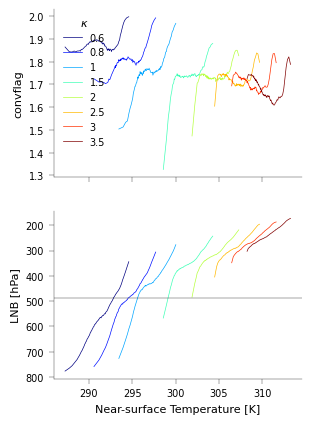

In [106]:
colors_kappa = plt.cm.jet(np.linspace(0, 1, n_kappa))
save_convflag_fig = False
fig, ax = plt.subplots(2, 1, figsize=(width['one_col'], 2 * width['one_col'] / ar), sharex=True)
for i in range(n_kappa):
    ax[0].plot(np.average(temp_quant3[i, ind_surf], axis=0, weights=lat_weights),
               np.average(convflag_quant3[i], axis=0, weights=lat_weights), color=colors_kappa[i], label=f'{tau_lw[i]}')
    ax[1].plot(np.average(temp_quant3[i, ind_surf], axis=0, weights=lat_weights),
               lzb(np.average(klzbs_quant3[i], axis=0, weights=lat_weights)), color=colors_kappa[i])
ax[1].axhline(pressure_ft_actual/100, color='k', lw=ax_linewidth)
ax[0].legend(title='$\kappa$')
ax[0].set_ylabel('convflag')
ax[-1].set_xlabel('Near-surface Temperature [K]')
ax[1].invert_yaxis()
ax[1].set_ylabel('LNB [hPa]')
# ax.set_ylim(1, 2)
if save_convflag_fig or save_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/convflag_{region}_{season}_kappa.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

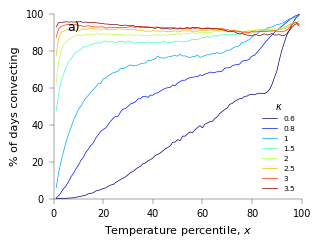

In [93]:
save_convfract_fig = False
fig, ax = plt.subplots(1, 1, figsize=(width['one_col'], width['one_col'] / ar), sharex=True)
for i in range(n_kappa):
    ax.plot(quant_plot, 100 * np.average(convfract_quant3[i], axis=0, weights=lat_weights),
            color=colors_kappa[i], label=f'{tau_lw[i]}')
ax.set_xlabel(percentile_label)
ax.set_xlim(0, 100)
ax.set_ylim(0, 100)
ax.set_ylabel('% of days convecting')
if season == 'summer':
    ax.legend(fontsize=5.4, title='$\kappa$', frameon=True, framealpha=1, edgecolor='white',title_fontsize=7, loc='lower right')
label_subplots(fig, [ax], ['a)'] if season == 'summer' else ['b)'], box_alpha=0)
# ax.legend(title='$\kappa$')
if save_convfract_fig or save_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/convfract_{region}_{season}_kappa.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

## Average Climate Plots
Show how mean temp, relative humidity and CAPE vary between climates.

In [94]:
temp_adiabat_av = np.zeros((n_kappa, n_lat))
for i in range(n_kappa):
    for j in range(n_lat):
        temp_adiabat_av[i, j] = get_temp_adiabat(temp_av[i, ind_surf, j], sphum_av[i, j], p_surface, pressure_ft_actual)

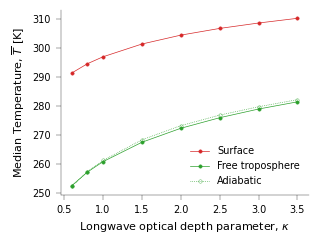

In [95]:
x_label_kappa = 'Longwave optical depth parameter, $\kappa$'
save_temp_av_fig = False
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar), sharex=True)
ax.plot(tau_lw, np.average(temp_av[:, ind_surf], axis=1, weights=lat_weights),
           color=default_colors[3],marker='o', label='Surface')
ax.plot(tau_lw, np.average(temp_av[:, ind_ft], axis=1, weights=lat_weights),
           color=default_colors[2],marker='o', label='Free troposphere')
ax.plot(tau_lw, np.average(temp_adiabat_av, axis=1, weights=lat_weights),
           color=default_colors[2], marker='o', linestyle=':', mfc='none', label='Adiabatic')
ax.set_xlabel(x_label_kappa)
ax.set_ylabel(f"{av_method.capitalize()} Temperature, $\overline{'{T}'}$ [K]")
ax.legend()

if save_temp_av_fig or save_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/temp_av_{region}_{season}_kappa.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

In [96]:
# Broken axis: https://matplotlib.org/stable/gallery/subplots_axes_and_figures/broken_axis.html
# x_label_kappa = 'Longwave optical depth parameter, $\kappa$'
# save_temp_av_fig = False
# fig, ax = plt.subplots(2,1, figsize=(width['one_col'], width['one_col']/ar), sharex=True)
# fig.subplots_adjust(hspace=0.06)  # adjust space between Axes
# 
# # plot the same data on both Axes
# ln1 = ax[0].plot(tau_lw, np.average(temp_av[:, ind_surf], axis=1, weights=lat_weights),
#            color=default_colors[3],marker='o', label='Surface')
# ln2 = ax[1].plot(tau_lw, np.average(temp_av[:, ind_ft], axis=1, weights=lat_weights),
#            color=default_colors[2],marker='o', label='Free troposphere')
# ln3 = ax[1].plot(tau_lw, np.average(temp_adiabat_av, axis=1, weights=lat_weights),
#            color=default_colors[2], marker='o', linestyle=':', mfc='none', label='Adiabatic')
# fig.supylabel(f"{av_method.capitalize()} Temperature, $\overline{'{T}'}$ [K]", fontsize=7, x=-0.01)
# ax[1].set_xlabel(x_label_kappa)
# 
# # zoom-in / limit the view to different portions of the data
# ax[0].set_ylim(289, 300)  # surf temp
# ax[1].set_ylim(250, 283)  # ft temp
# 
# # Legend combining all lines
# lns = ln1+ln2+ln3
# labs = [l.get_label() for l in lns]
# ax[0].legend(lns, labs)
# 
# # Broken axis stuff
# ax[0].spines.bottom.set_visible(False)
# ax[0].xaxis.set_ticks_position('none') 
# d = .5  # proportion of vertical to horizontal extent of the slanted line
# kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
#               linestyle="none", color='k', mec='k', mew=1, clip_on=False)
# ax[0].plot([0], [0], transform=ax[0].transAxes, **kwargs)
# ax[1].plot([0], [1], transform=ax[1].transAxes, **kwargs)
# 
# if save_temp_av_fig or save_fig:
#     fig.savefig(f"/Users/joshduffield/Desktop/temp_av_{region}_{season}_kappa.pdf",
#                 dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

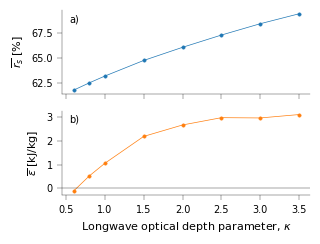

In [97]:
save_r_e_av_fig = False
fig, ax = plt.subplots(2,1, figsize=(width['one_col'], width['one_col']/ar), sharex=True)
# fig.subplots_adjust(hspace=0.06)  # adjust space between Axes
ax[0].plot(tau_lw, 100*np.average(r_av, axis=1, weights=lat_weights),
           color=default_colors[0],marker='o')
ax[1].plot(tau_lw, np.average(epsilon_av, axis=1, weights=lat_weights),
           color=default_colors[1],marker='o')
ax[1].axhline(0, color='k', lw=ax_linewidth)
label_subplots(fig, ax, fontsize=7, pos_x=5, pos_y=-3)
ax[0].set_ylabel('$\overline{r_s}$ [%]')
ax[1].set_ylabel('$\overline{\epsilon}$ [kJ/kg]')
ax[1].set_xlabel(x_label_kappa)

if save_r_e_av_fig or save_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/r_e_av_{region}_{season}_kappa.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

## Anomaly Plots
For each simulation, show anomaly of the four variables which influence the scaling factor.

In [98]:
temp_anom = temp_quant3 - np.expand_dims(temp_av, axis=-1)
r_anom = r_quant3 - np.expand_dims(r_av, axis=-1)
epsilon_anom = epsilon_quant3 - np.expand_dims(epsilon_av, axis=-1)

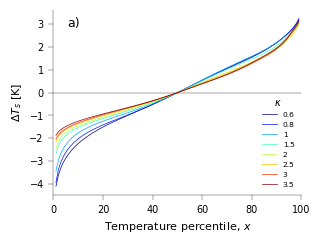

In [99]:
save_temp_s_anom_fig = False
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
for i in range(n_kappa):
    ax.plot(quant_plot, np.average(temp_anom[i, ind_surf], axis=0, weights=lat_weights),
               color=colors_kappa[i], label=f'{tau_lw[i]}')
ax.axhline(0, color='k', lw=ax_linewidth)
ax.set_ylabel("$\Delta T_s$ [K]")
ax.set_xlabel(percentile_label)
ax.set_xlim(0, 100)
ax.legend(fontsize=5.4, title='$\kappa$', frameon=True, framealpha=1, edgecolor='white',
          title_fontsize=7, loc='lower right')
label_subplots(fig, [ax], ['a)'] if not is_land_data else ['b)'], box_alpha=0)

if save_fig or save_temp_s_anom_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/temp_s_anom_{region.lower()}_{season}.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

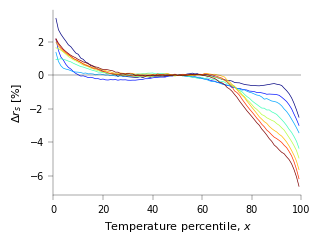

In [107]:
save_r_anom_fig = False
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
for i in range(n_kappa):
    ax.plot(quant_plot, 100 * np.average(r_anom[i], axis=0, weights=lat_weights),
               color=colors_kappa[i], label=f'{tau_lw[i]}')
ax.axhline(0, color='k', lw=ax_linewidth)
ax.set_ylabel("$\Delta r_s$ [%]")
ax.set_xlabel(percentile_label)
ax.set_xlim(0, 100)
# ax.legend(fontsize=5.4, title='$\kappa$', frameon=True, framealpha=1, edgecolor='white',
#           title_fontsize=7, loc='lower right')
# label_subplots(fig, [ax], ['a)'] if not is_land_data else ['b)'], box_alpha=0)

if save_fig or save_r_anom_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/r_anom_{region.lower()}_{season}.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

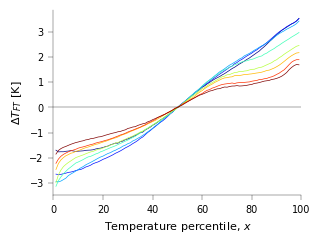

In [101]:
save_temp_ft_anom_fig = False
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
for i in range(n_kappa):
    ax.plot(quant_plot, np.average(temp_anom[i, ind_ft], axis=0, weights=lat_weights),
               color=colors_kappa[i], label=f'{tau_lw[i]}')
ax.axhline(0, color='k', lw=ax_linewidth)
ax.set_ylabel("$\Delta T_{FT}$ [K]")
ax.set_xlabel(percentile_label)
ax.set_xlim(0, 100)
# ax.legend(fontsize=5.4, title='$\kappa$', frameon=True, framealpha=1, edgecolor='white',
#           title_fontsize=7, loc='lower right')
# label_subplots(fig, [ax], ['a)'] if not is_land_data else ['b)'], box_alpha=0)

if save_fig or save_temp_ft_anom_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/temp_ft_anom_{region.lower()}_{season}.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

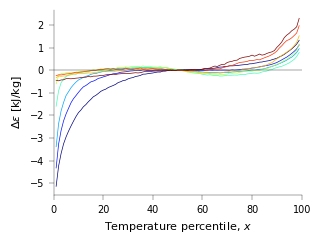

In [102]:
save_e_anom_fig = False
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
for i in range(n_kappa):
    ax.plot(quant_plot, np.average(epsilon_anom[i], axis=0, weights=lat_weights),
               color=colors_kappa[i], label=f'{tau_lw[i]}')
ax.axhline(0, color='k', lw=ax_linewidth)
ax.set_ylabel("$\Delta \epsilon$ [kJ/kg]")
ax.set_xlabel(percentile_label)
ax.set_xlim(0, 100)
# ax.legend(fontsize=5.4, title='$\kappa$', frameon=True, framealpha=1, edgecolor='white',
#           title_fontsize=7, loc='lower right')
# label_subplots(fig, [ax], ['a)'] if not is_land_data else ['b)'], box_alpha=0)

if save_fig or save_e_anom_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/e_anom_{region.lower()}_{season}.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

## Scaling Factor Plots

In [103]:
sf_simulated = np.diff(temp_quant3[:, ind_surf], axis=0)/np.diff(temp_av[:, ind_surf], axis=0)[:, :, np.newaxis]
sf_theory = {'linear': np.zeros((n_kappa-1, n_lat, n_quant)), 'non_linear': np.zeros((n_kappa-1, n_lat, n_quant)), 
             'simple': np.zeros((n_kappa-1, n_lat, n_quant)), 
             'sce_non_linear': np.ones((n_kappa-1, n_lat, n_quant)), 'sce_simple': np.ones((n_kappa-1, n_lat, n_quant))}
keys_sf_breakdown = {var+'_mean_change': ['t0', 't0_r0', 'r0', 'e0'] for var in ['t', 'r', 'e']}
keys_sf_breakdown['anomaly_change'] = ['r', 't0_r', 'ft', 'e']
sf_theory_breakdown = {key1: {key2: np.zeros((n_kappa-1, n_lat, n_quant)) for key2 in keys_sf_breakdown[key1]} for key1 in keys_sf_breakdown}
for j in range(n_kappa-1):
    for i in range(n_lat):
        for key in sf_theory:
            sf_theory[key][j, i], _, _, info_cont, _ = get_scaling_factor_theory(temp_av[j:j+2, ind_surf, i], temp_quant3[j:j+2, ind_surf, i], 
                                                                              sphum_av[j:j+2, i], sphum_quant3[j:j+2, i], p_surface, pressure_ft_actual,
                                                                              temp_av[j:j+2, ind_ft, i], temp_quant3[j:j+2, ind_ft, i], 
                                                                              z_av[j:j+2, ind_ft, i], z_quant3[j:j+2, ind_ft, i],
                                                                              non_linear='non_linear' in key, use_temp_adiabat=True, 
                                                                              strict_conv_eqb='sce' in key, 
                                                                              simple='simple' in key)
            if key == 'linear':
                # Only record breakdown for linear case as easier to interpret
                for key1 in keys_sf_breakdown:
                    for key2 in keys_sf_breakdown[key1]:
                        sf_theory_breakdown[key1][key2][j, i] = info_cont[key1][key2]

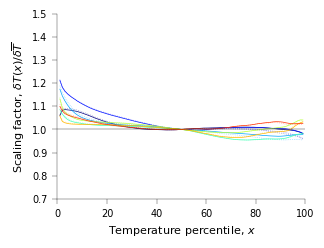

In [104]:
save_sf_fig = False
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
theory_plot = 'simple'
for i in range(n_kappa-1):
    ax.plot(quant_plot, np.average(sf_simulated[i], axis=0, weights=lat_weights),
               color=colors_kappa[i], label=f'{tau_lw[i]}')
    ax.plot(quant_plot, np.average(sf_theory[theory_plot][i], axis=0, weights=lat_weights),
               color=colors_kappa[i], linestyle=':', alpha=0.5)
ax.axhline(1, color='k', lw=ax_linewidth)
ax.set_ylabel('Scaling factor, $\delta T(x)/\delta \overline{T}$')
ax.set_xlabel(percentile_label)
ax.set_xlim(0, 100)
ax.set_ylim(0.7, 1.5)
# ax.legend(fontsize=5.4, title='$\kappa$', frameon=True, framealpha=1, edgecolor='white',
#           title_fontsize=7, loc='upper right')

if save_fig or save_sf_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/sf_{region.lower()}_{season}.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

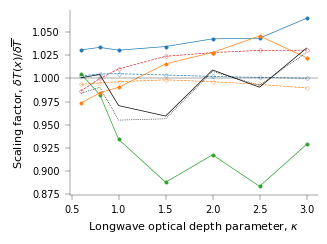

In [105]:
save_sf_breakdown_fig = False
quant_breakdown = 90
quant_breakdown_ind = int(np.where(quant_plot==quant_breakdown)[0])
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
ax.plot(tau_lw[:-1], 1+np.average(sf_theory_breakdown['t_mean_change']['t0'], axis=1, weights=lat_weights)[:, quant_breakdown_ind], marker='o', color=default_colors[3], linestyle='--', mfc='none')
ax.plot(tau_lw[:-1], 1+np.average(sf_theory_breakdown['t_mean_change']['r0'], axis=1, weights=lat_weights)[:, quant_breakdown_ind], marker='o', color=default_colors[0], linestyle='--', mfc='none')
ax.plot(tau_lw[:-1], 1+np.average(sf_theory_breakdown['t_mean_change']['e0'], axis=1, weights=lat_weights)[:, quant_breakdown_ind], marker='o', color=default_colors[1], linestyle='--', mfc='none')

ax.plot(tau_lw[:-1], 1+np.average(sf_theory_breakdown['anomaly_change']['r'], axis=1, weights=lat_weights)[:, quant_breakdown_ind], marker='o', color=default_colors[0])
ax.plot(tau_lw[:-1], 1+np.average(sf_theory_breakdown['anomaly_change']['ft'], axis=1, weights=lat_weights)[:, quant_breakdown_ind], marker='o', color=default_colors[2])
ax.plot(tau_lw[:-1], 1+np.average(sf_theory_breakdown['anomaly_change']['e'], axis=1, weights=lat_weights)[:, quant_breakdown_ind], marker='o', color=default_colors[1])


ax.plot(tau_lw[:-1], np.average(sf_simulated, axis=1, weights=lat_weights)[:, quant_breakdown_ind],
           color='k')
ax.plot(tau_lw[:-1], np.average(sf_theory[theory_plot], axis=1, weights=lat_weights)[:, quant_breakdown_ind],
           color='k', linestyle=':')
ax.axhline(1, color='k', lw=ax_linewidth)

ax.set_ylabel('Scaling factor, $\delta T(x)/\delta \overline{T}$')
ax.set_xlabel(x_label_kappa)

if save_fig or save_sf_breakdown_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/sf_breakdown_{region.lower()}_{season}.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)